# Data : 
 * Adialer.C
 * Agent.FYI
 * Allaple.A
 * Allaple.L
 * Alueron.gen!J
 * Autorun.K
 * C2LOP.P
 * C2LOP.gen!g
 * Dialplatform.B
 * Dontovo.A
 * Fakerean
 * Instantaccess
 * Lolyda.AA1
 * Lolyda.AA2
 * Lolyda.AA3
 * Lolyda.AT
 * Malex.gen!J
 * Obfuscator.AD
 * Rbot!gen
 * Skintrim.N
 * Swizzor.gen!E
 * Swizzor.gen!I
 * VB.AT
 * Wintrim.BX
 * Yuner.A

# Image-based Malware Classification using CNN




# Preprocessing - Converting to images

Folder **data** chứa malware để test sau khi train model:

In [1]:
root = "../Dataset/malimg_paper_dataset_imgs/"

Chuyển file **.byte** sang **.png**

In [2]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt


# Preprocessing - Generate the dataset

Folder **malimg_paper_dataset_imgs** chứa dataset training cho model

In [3]:
path_root = "../Dataset/malimg_paper_dataset_imgs"

Folder contains 9339 images of malware corresponding with their family

In [4]:
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


Using **ImageDataGenerator.flow_from_directory()** to create tensor data corresponding with the images.
  * **target_size** : resize to 64x64.
  * **batch_size** : each patch contains 10.000 tensor 

Check the class

In [5]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

From **batches** create **image** and **label**

In [6]:
imgs, labels = next(batches)

check the **image shape**,  64x64x3 [width x length x depth]

In [7]:
imgs.shape

(9339, 64, 64, 3)

check the **label shape**  (batch_size, number of classes).

In [8]:
labels.shape

(9339, 25)

Plots some marwale images

In [9]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

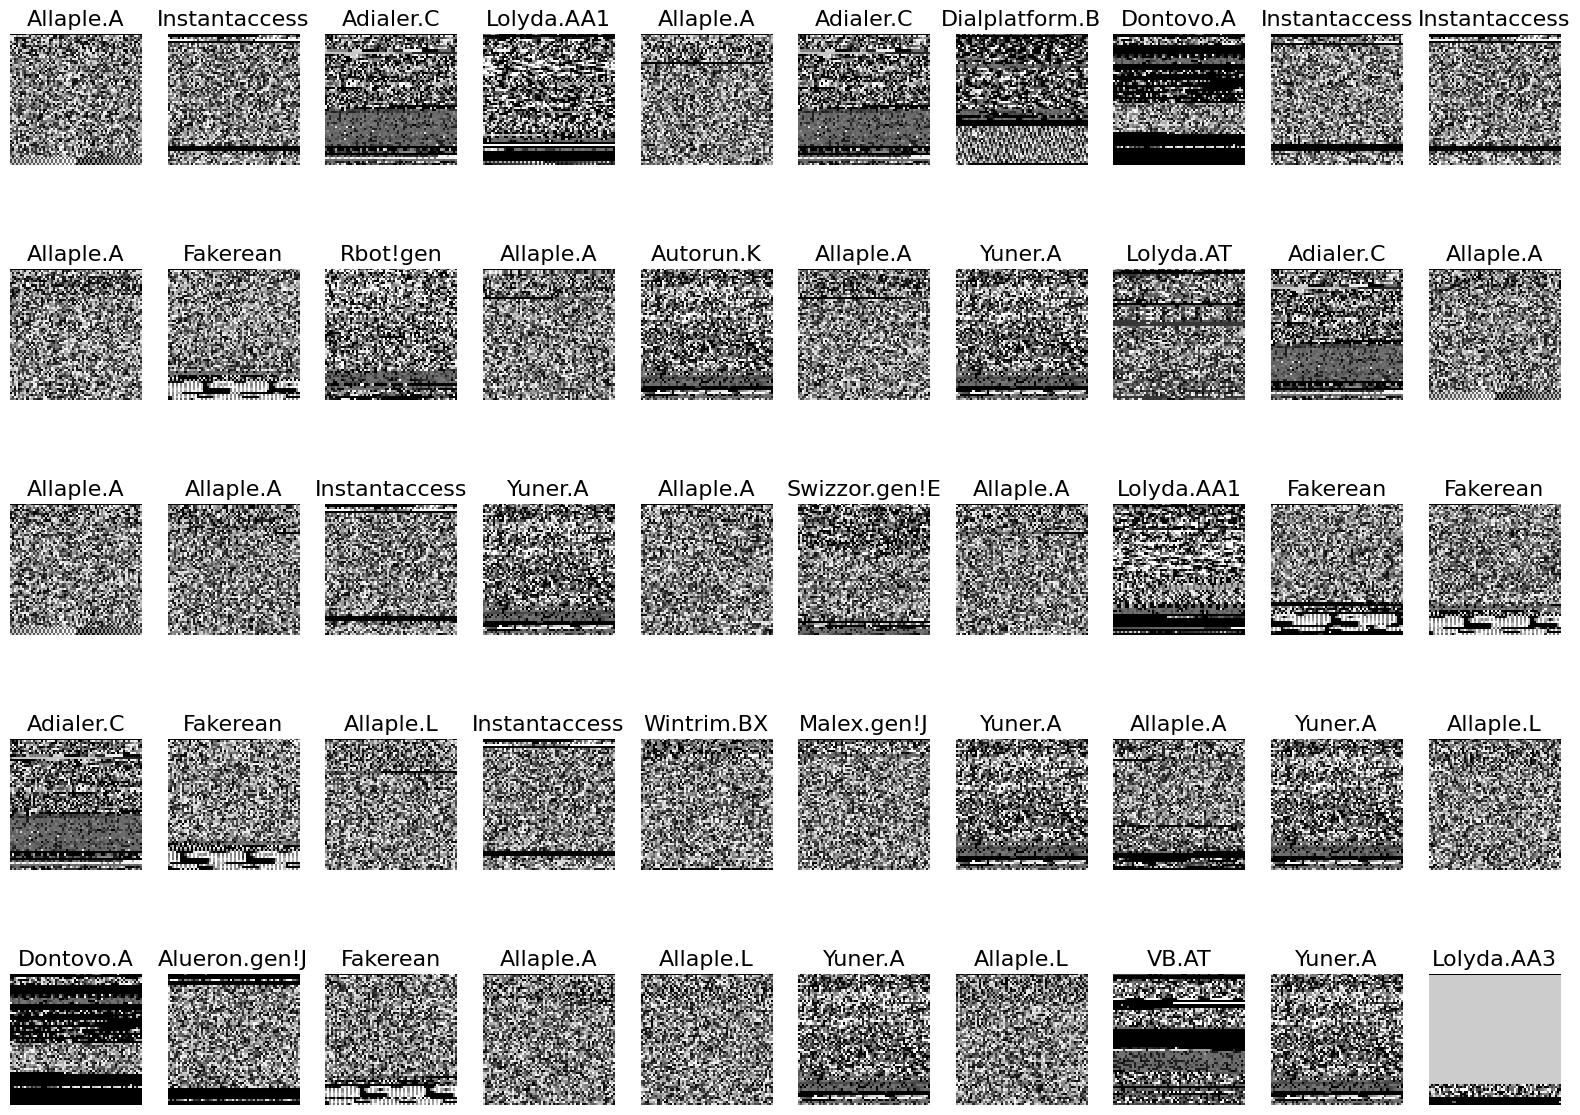

In [10]:
plots(imgs, titles = labels)

# Analyse 

In [11]:
classes = batches.class_indices.keys()

In [12]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

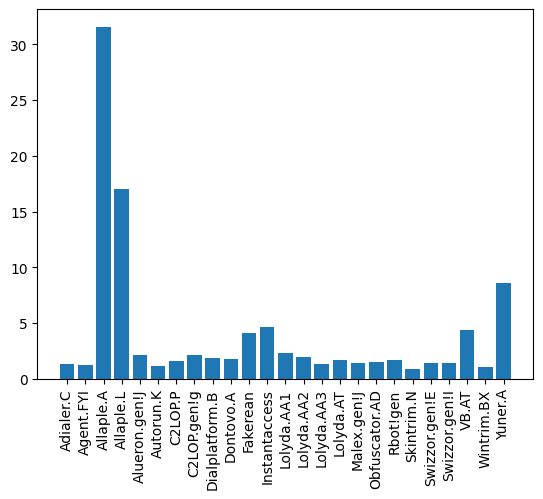

In [13]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

# Train and test

Create train set and test set

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [15]:
X_train.shape

(6537, 64, 64, 3)

In [16]:
X_test.shape

(2802, 64, 64, 3)

In [17]:
y_train.shape

(6537, 25)

In [18]:
y_test.shape

(2802, 25)

## Convolutional Neural Network Model

**CNN** model architecture:

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, Relu activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64x64x3

In [19]:
import keras
import tensorflow
import dill as pickle
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC


We want **25** classes as output.

In [20]:
num_classes = 25

Building the model

In [21]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model


In [22]:
from keras import backend as K

def recall_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, y_pred):
    precision = precision_m(y_test, y_pred)
    recall = recall_m(y_test, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [23]:
Malware_model = malware_model()

In [24]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

In [25]:
y_train.shape

(6537, 25)

In [26]:
y_train_new = np.argmax(y_train, axis=1)

In [27]:
y_train_new

array([24, 22,  3, ..., 19,  1,  0], dtype=int64)

In [28]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_new),
                                                 y = y_train_new)
#class_weights = {i : class_weights[i] for i in range(5)}

class_weights = {l:c for l,c in zip(np.unique(y_train_new), class_weights)}



In [29]:
Malware_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m,precision_m, recall_m,AUC()])

In [30]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,  class_weight=class_weights)

Epoch 1/20
205/205 [==============================] - 12s 51ms/step - loss: 0.2054 - f1_m: 0.0253 - precision_m: 0.1898 - recall_m: 0.0139 - auc: 0.6596 - val_loss: 0.1183 - val_f1_m: 0.1373 - val_precision_m: 0.8583 - val_recall_m: 0.0763 - val_auc: 0.9391
Epoch 2/20
205/205 [==============================] - 11s 51ms/step - loss: 0.0971 - f1_m: 0.3343 - precision_m: 0.7455 - recall_m: 0.2243 - auc: 0.9296 - val_loss: 0.0693 - val_f1_m: 0.4422 - val_precision_m: 0.7592 - val_recall_m: 0.3166 - val_auc: 0.9827
Epoch 3/20
205/205 [==============================] - 11s 52ms/step - loss: 0.0662 - f1_m: 0.4696 - precision_m: 0.7220 - recall_m: 0.3538 - auc: 0.9638 - val_loss: 0.0582 - val_f1_m: 0.5972 - val_precision_m: 0.8779 - val_recall_m: 0.4571 - val_auc: 0.9853
Epoch 4/20
205/205 [==============================] - 11s 54ms/step - loss: 0.0533 - f1_m: 0.5287 - precision_m: 0.7133 - recall_m: 0.4242 - auc: 0.9739 - val_loss: 0.0587 - val_f1_m: 0.5966 - val_precision_m: 0.7506 - val_rec

# Model result

In [31]:
scores = Malware_model.evaluate(X_test, y_test)

88/88 [==============================] - 1s 10ms/step - loss: 0.0168 - f1_m: 0.9511 - precision_m: 0.9537 - recall_m: 0.9486 - auc: 0.9982


In [32]:
loss, accuracy, f1_score, precision, recall = Malware_model.evaluate(X_test, y_test)

88/88 [==============================] - 1s 10ms/step - loss: 0.0168 - f1_m: 0.9511 - precision_m: 0.9537 - recall_m: 0.9486 - auc: 0.9982


In [33]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9511012434959412


## Confusion Matrix

Lets analyse our results.

In [34]:
import numpy as np
import pandas as pd

In [35]:
y_pred = np.argmax(Malware_model.predict(X_test), axis=-1)

88/88 [==============================] - 1s 9ms/step


In [36]:
y_pred

array([ 2, 16,  3, ..., 18,  2,  2], dtype=int64)

In [37]:
y_test2 = np.argmax(y_test, axis=1)

In [38]:
y_test2

array([ 2, 16,  3, ..., 18,  2,  2], dtype=int64)

In [39]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [40]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

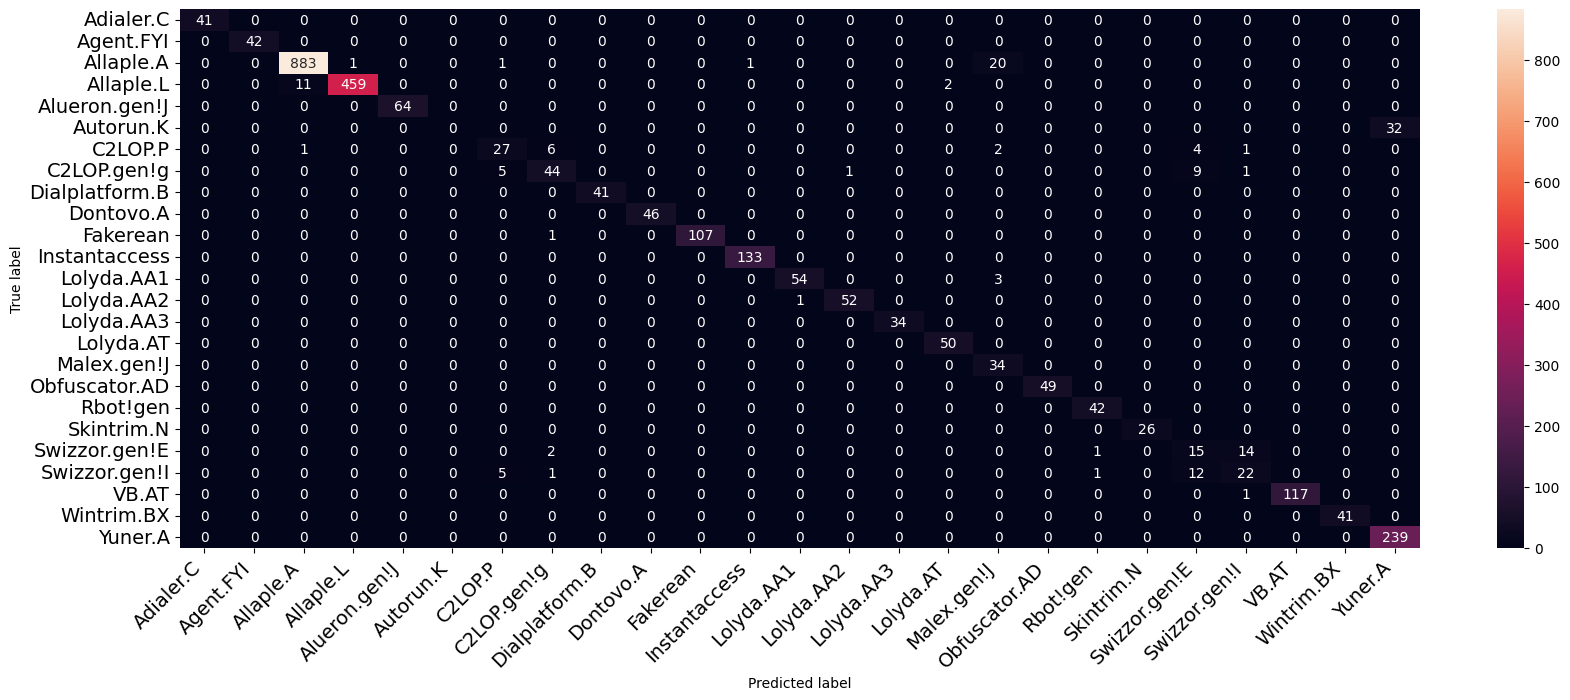

In [41]:
class_names= list(batches.class_indices.keys())
with open('../Classifier/Malware_Classifier/Malware_classes.pkl','wb') as file:
    pickle.dump(class_names, file)
file.close()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

## Acc, Loss, Precision, Recall, F1

In [42]:
results = pd.DataFrame({ 'CNN Model': 'Malware model',    
    'Accuracy': [scores[1]],
    'Loss': [scores[0]],
    'Precision': [scores[3]],
    'Recall' : [scores[4]],
    'f1 score': [scores[2]]})

In [43]:
results

,CNN Model,Accuracy,Loss,Precision,Recall,f1 score
0,Malware model,0.951101,0.016801,0.948587,0.998191,0.953696


In [44]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(Malware_model.predict(X_test), axis=-1)
print(classification_report(Y_test, y_pred))

88/88 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        42
           2       0.99      0.97      0.98       906
           3       1.00      0.97      0.98       472
           4       1.00      1.00      1.00        64
           5       0.00      0.00      0.00        32
           6       0.71      0.66      0.68        41
           7       0.81      0.73      0.77        60
           8       1.00      1.00      1.00        41
           9       1.00      1.00      1.00        46
          10       1.00      0.99      1.00       108
          11       0.99      1.00      1.00       133
          12       0.98      0.95      0.96        57
          13       0.98      0.98      0.98        53
          14       1.00      1.00      1.00        34
          15       0.96      1.00      0.98        50
          16       0.58     

c:\Users\KietVu\Testplace\Malware-Detection-using-Machine-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KietVu\Testplace\Malware-Detection-using-Machine-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KietVu\Testplace\Malware-Detection-using-Machine-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

# Save and use model

## Save

In [45]:
with open('../Classifier/Malware_Classifier/pickel_malware_classifier.pkl','wb') as file:
    pickle.dump(Malware_model, file)
file.close()

Use model to check malware image

In [46]:
import keras.utils
import tensorflow as tf
plt.figure(figsize=(10, 10))

image_paths = []
rootdir = './data/img/'
with open('../Classifier/Malware_Classifier/pickel_malware_classifier.pkl','rb') as file1:
    pickle_model = pickle.load(file1)
file1.close()

pickle_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

<Figure size 1000x1000 with 0 Axes>

In [47]:
print(type(pickle_model))

<class 'keras.engine.sequential.Sequential'>


In [51]:
tf.keras.saving.save_model(
    model = Malware_model,
    filepath='../Classifier/Malware_Classifier/tf_save_model.keras',
    overwrite=True,
    save_format='tf'
)